# Chapter 10: Statistics - The Monte Carlo Method


In this chapter, we take a brief look at the Monte Carlo Method. We start by introducing the Linear Congruential Generator (LCG) to generate random numbers.

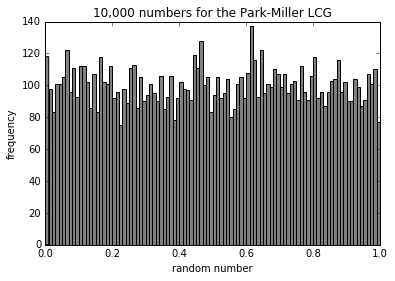

In [25]:
import numpy as np
import pylab as pl
%matplotlib inline

#Define a function that returns LCG (pseudo) random numbers
def LCG (a=16807,b=0,M=2147483647):
    N1 = (a*LCG.seed+b) % M
    #print(LCG.seed)
    LCG.seed = N1
    return N1/M

#Initialize the seed:
LCG.seed=10135

#Generate an array of random numbers from the the LCG
nr=10000
r=np.zeros(nr)
for i in range(nr):
    r[i] = LCG(seed)

#Plot a histogram of the values:
pl.hist(r,bins=100,color='gray')
pl.xlabel('random number')
pl.ylabel('frequency')
pl.title('10,000 numbers for the Park-Miller LCG')
pl.show()

We can then use this LCG to generate numbers that are exponentially distributed with a time constant $\tau$:


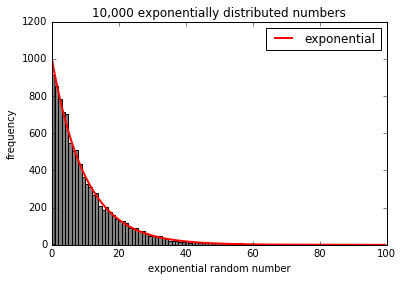

In [26]:
#using the array of values, r, we transform these into values y:
tau = 10
y = -tau * np.log(r) #numpy log is really ln
#Plot a histogram of the values:
n,bins,patches=pl.hist(y,bins=100,color='gray')
pl.xlabel('exponential random number')
pl.ylabel('frequency')
pl.title('10,000 exponentially distributed numbers')
#plot the corresponding exponential (normalized by the number of y values)
xi=np.linspace(0,y.max(),100)
norm = y.size/(bins[1]-bins[0])/tau
pl.plot(xi,norm*np.exp(-xi/tau),color='red',lw=2,label="exponential")
pl.legend()
pl.show()

The numpy.random module has a functions to generate random numbers from a variety of distributions, a few are illustrated below:

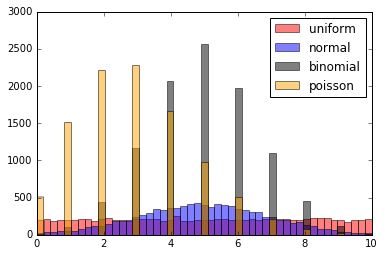

In [45]:
nr = 10000 # number of random numbers to generate
#Uniform distribution:
xmin=0
xmax=10
xunif = np.random.uniform(xmin,xmax,nr)
#Normal distribution:
mu = 5
sigma = 2
xnorm = np.random.normal(mu,sigma,nr)
#Binomial distribution:
N=10
p=0.5
xbinom = np.random.binomial(N,p,nr)
#Poisson distribution:
n=3
xpoiss = np.random.poisson(n,nr)
#Plot them all:
bins = np.linspace(0,10,50)
pl.hist(xunif,bins=bins,color='red',alpha=0.5,label='uniform')
pl.hist(xnorm,bins=bins,color='blue',alpha=0.5,label='normal')
pl.hist(xbinom,bins=bins,color='black',alpha=0.5,label='binomial')
pl.hist(xpoiss,bins=bins,color='orange',alpha=0.5,label='poisson')
pl.legend()
pl.show()

## 10.2 Monte Carlo Simulations

We start by simulating the outcome of counting the number of heads in 10 coin tosses with an unfair coin that has a probability, $p=0.7$, of landing on heads. To simulate a single coin toss, we can generate a uniform random number, $r$, and count it as heads if $r<1-p=0.7$, which will happen 70% of the time since $r$ is uniform.

To simulate 10 coin tosses, we generate 10 random numbers and count how many are smaller than 0.7:

In [52]:
#Simulation of a set of 10 coin tosses:
#Make 10 random numbers between 0 and 1:
N=10
r = np.random.uniform(0.0,1.0,N)
#Count how many are smaller than 0.7
nheads = r[r<0.7].size
print(nheads," heads in 10 tosses")

6  heads in 10 tosses


We now repeat this many time to see what distribution of outcomes we get:

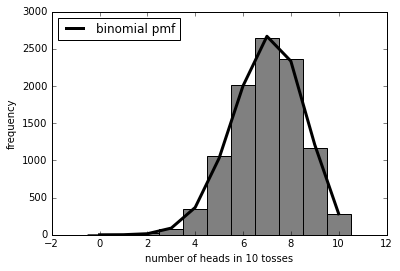

In [64]:
import scipy.stats as stats
Nexp=10000 # repeat the experiment 10,000 times
nheads = np.zeros(Nexp) # array to hold the result of each experiment
N=10
#Conduct the Nexp experiments:
for i in range(Nexp):
    #A single experiment
    r = np.random.uniform(0.0,1.0,N)
    #Count how many are smaller than 0.7, add to array of results
    nheads[i] = r[r<0.7].size    
    
#Plot the result:
bins=np.linspace(-0.5,N+0.5,N+2)
pl.hist(nheads,bins=bins, color='gray')
pl.xlabel("number of heads in 10 tosses")
pl.ylabel("frequency")
#Plot the binomial distribution
norm = Nexp/(bins[1]-bins[0]) #normalization, since the histogram is not normalized
xi=np.arange(N+1)
pl.plot(xi,norm*stats.binom.pmf(xi,N,0.7),color='black',lw=3,label='binomial pmf')
pl.legend(loc='best')
pl.show()

We now simulate a more complex situation, namely the distribution of profits expected in our poutine restaurant if we stay open an extra hour.

Mean profits: $46.08


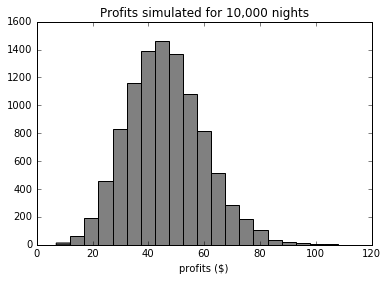

In [75]:
Nexp = 10000 # the number of experiments (nights)
profits = np.zeros(Nexp)# array to hold the profits for each night
#Perform Nexp experiments
for iexp in range(Nexp):
    #For each night:
    #Generate a random number of customers with (Poisson) mean 15
    ncustomers = np.random.poisson(15)
    #For each customer, simulate their order:
    for icustomer in range(ncustomers):
        #Generate a random number of poutines with Poisson mean of 1
        #Repeat until the number is bigger than 0
        npoutines=0
        while(npoutines<1):
            npoutines = np.random.poisson(1)
        #For each poutine, decide what type it is
        for ipoutine in range(npoutines):
            #Draw a uniform random number between 0 and 1 for the choice
            choice = np.random.uniform()
            #based on the type, add in the profits for that night:
            if choice<0.7: #traditional
                profits[iexp] = profits[iexp]+2.00 
            elif choice>=0.7 and choice <0.9:#pork
                profits[iexp] = profits[iexp]+2.50 
            else:#vegetarian
                profits[iexp] = profits[iexp]+0.50
                
print("Mean profits: ${:.2f}".format(profits.mean())) 
#Plot it:
pl.hist(profits,bins=20,color='gray')
pl.xlabel('profits ($)')
pl.title('Profits simulated for 10,000 nights')
pl.show()